# **🧠 Multi-Label Emotion Classification using RoBERTa on GoEmotions Kaggle Dataset**

# **📋 Project Description**

This project focuses on multi-label emotion detection from text using the GoEmotions dataset available on Kaggle.
Each text sample can express multiple emotions simultaneously (e.g., joy, sadness, and surprise), requiring a multi-label classification approach.
We leverage RoBERTa, a state-of-the-art transformer model, fine-tuned to capture nuanced emotional patterns in human language.

---
# 🎯 **Project Goal**

The main goal of this project is to build an AI model capable of understanding and detecting human emotions in text with high accuracy.
By combining deep learning and transformer-based architectures, the project aims to advance emotion-aware systems that can improve applications such as sentiment analysis, chatbots, and mental health monitoring.

---
# **The project includes:**

- 🧹 Data preprocessing and label binarization for multi-emotion setup

- 📊 Colorful visual analysis to explore emotion distributions, co-occurrence patterns, and dataset balance

- 🤖 Model fine-tuning using the Hugging Face Trainer API

- 🎯 Evaluation with Micro and Macro F1 scores for robust performance measurement

- 🌈 Color-coded prediction samples for clear comparison between true and predicted emotions

# **install/upgrade required packages - imports and config**


In [1]:
!pip install --upgrade --quiet transformers datasets accelerate evaluate

import warnings
warnings.filterwarnings("ignore")
import torch
import os, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import cm
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AutoTokenizer
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

2025-10-11 12:03:51.523031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760184231.698187      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760184231.744194      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda



# 📊 **Preparing the GoEmotions Dataset for Multi-Label Emotion Analysis** 
Loads and preprocesses the GoEmotions dataset by identifying emotion columns and mapping each text sample to its corresponding emotion labels.

In [2]:
DATA_PATH = "/kaggle/input/go-emotions-google-emotions-dataset/go_emotions_dataset.csv"
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
if "text" in df.columns:
    TEXT_COL = "text"
elif "comment" in df.columns:
    TEXT_COL = "comment"
else:
    TEXT_COL = df.columns[0]
print("Text col:", TEXT_COL)

possible_emotion_cols = [c for c in df.columns if c not in [TEXT_COL, "id"]]
EMOTIONS = [c for c in possible_emotion_cols if set(df[c].dropna().unique()).issubset({0,1,0.0,1.0})]
print(f"Detected {len(EMOTIONS)} emotion columns")
df['labels_list'] = df.apply(lambda r: [emo for emo in EMOTIONS if int(r[emo])==1], axis=1)
print("Example labels:", df['labels_list'].head(3).tolist())

Raw shape: (211225, 31)
Text col: text
Detected 29 emotion columns
Example labels: [['sadness'], ['example_very_unclear'], ['neutral']]


Detected 28 emotion columns: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment']...


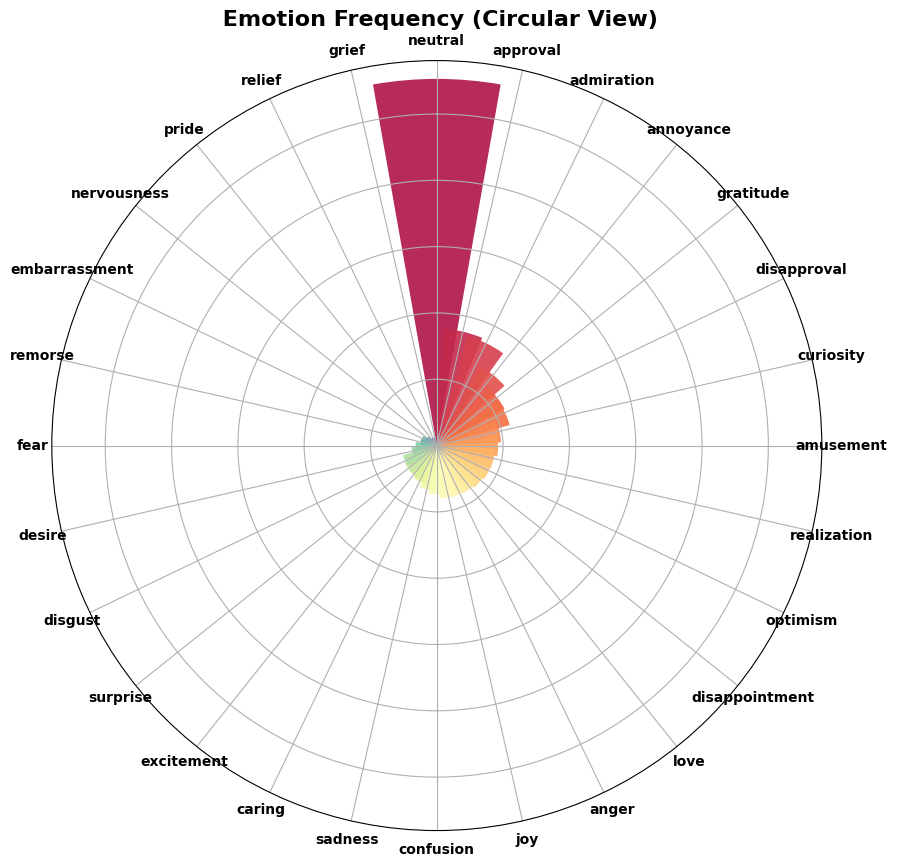

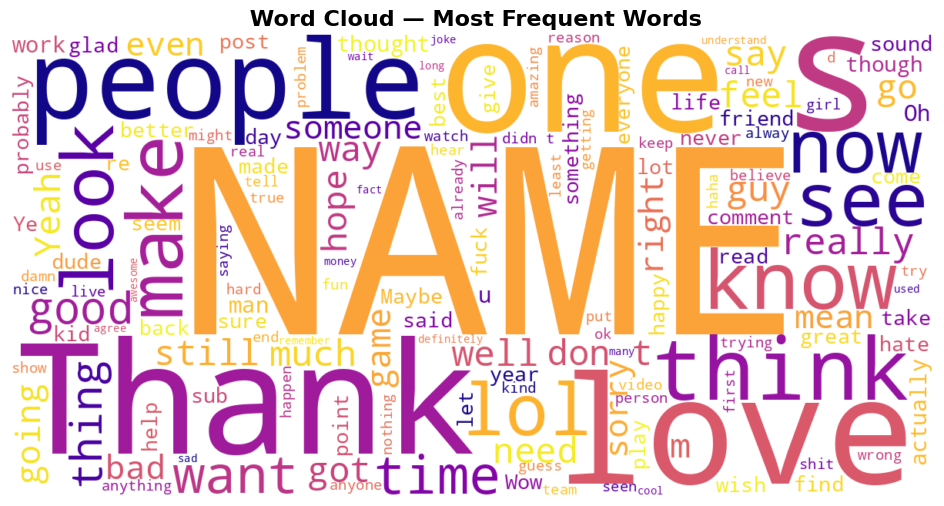

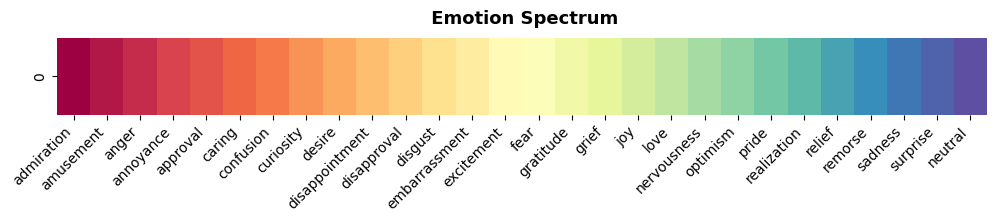

In [3]:
if "text" in df.columns:
    TEXT_COL = "text"
elif "comment" in df.columns:
    TEXT_COL = "comment"
else:
    TEXT_COL = df.columns[0]

# Detect emotion columns safely
possible_emotion_cols = [c for c in df.columns if c not in [TEXT_COL, "id", "labels_list"]]

EMOTIONS = []
for c in possible_emotion_cols:
    unique_vals = df[c].dropna().unique()
    # Check only numeric/boolean columns
    if all(isinstance(v, (int, float, np.integer, np.floating)) for v in unique_vals):
        if set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            EMOTIONS.append(c)

print(f"Detected {len(EMOTIONS)} emotion columns: {EMOTIONS[:10]}...")

#  Visualizations 
emotion_counts = df[EMOTIONS].sum().sort_values(ascending=False)
colors = sns.color_palette("Spectral", len(emotion_counts))

# Circular bar plot
plt.figure(figsize=(10,10), facecolor='white')
ax = plt.subplot(111, polar=True)
angles = np.linspace(0, 2 * np.pi, len(emotion_counts), endpoint=False).tolist()
bars = ax.bar(angles, emotion_counts.values, color=colors, alpha=0.9, width=0.35)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(emotion_counts.index, fontsize=10, fontweight='bold')
ax.set_yticklabels([])
ax.set_title(" Emotion Frequency (Circular View)", fontsize=16, fontweight='bold', pad=25)
plt.show()

# Word cloud
text_data = " ".join(df[TEXT_COL].astype(str).tolist())
wordcloud = WordCloud(
    width=1200, height=600,
    background_color="white",
    colormap="plasma",
    contour_color="steelblue",
    contour_width=2,
    max_words=150
).generate(text_data)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(" Word Cloud — Most Frequent Words", fontsize=16, fontweight='bold')
plt.show()

# Gradient emotion strip
plt.figure(figsize=(12,1))
sns.heatmap(np.linspace(0,1,len(EMOTIONS)).reshape(1,-1),
            cmap="Spectral", cbar=False, xticklabels=EMOTIONS)
plt.xticks(rotation=45, ha="right")
plt.title(" Emotion Spectrum", fontsize=13, pad=10, fontweight='bold')
plt.show()

In [4]:
emotion_cols = df.columns[3:].tolist()  

df['labels_list'] = df[emotion_cols].apply(lambda x: [emo for emo in emotion_cols if x[emo] == 1], axis=1)

print(df[['text', 'labels_list']].head(3))

                                                text labels_list
0                                    That game hurt.   [sadness]
1   >sexuality shouldn’t be a grouping category I...          []
2     You do right, if you don't care then fuck 'em!   [neutral]



# **Train-Validation Split with Stratified Sampling**
Splits the dataset into training and validation sets while preserving the distribution of primary emotion labels for balanced model evaluation.

In [5]:
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['labels_list'])
EMOTIONS = list(mlb.classes_)
print("Num emotions after mlb:", len(EMOTIONS))

for i,emo in enumerate(EMOTIONS):
    df[f"label_{emo}"] = Y[:,i]

def primary_label(labels):
    return labels[0] if len(labels)>0 else "neutral"
df['primary_label'] = df['labels_list'].apply(primary_label)

train_df, val_df = train_test_split(df, test_size=0.12, random_state=SEED, stratify=df['primary_label'])
print("Train/Val sizes:", len(train_df), len(val_df))
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Num emotions after mlb: 28
Train/Val sizes: 185878 25347


# 🤖 **Tokenization and Dataset Preparation for RoBERTa Model** 

Initializes the RoBERTa tokenizer and constructs Hugging Face Dataset objects for training and validation sets.


In [6]:

MODEL_NAME = "roberta-base"   

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def make_dataset(df_part):
    ds = Dataset.from_pandas(df_part[[TEXT_COL, 'labels_list']].copy())
    
    def to_multihot(example):
        lab = np.zeros(len(EMOTIONS), dtype=int)
        for L in example['labels_list']:
            if L in EMOTIONS:
                lab[EMOTIONS.index(L)] = 1
        example['labels'] = lab.tolist()
        return example

    ds = ds.map(to_multihot)
    return ds

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

def tokenize_fn(examples):
    return tokenizer(examples[TEXT_COL], truncation=True, padding='max_length', max_length=128)

dataset = dataset.map(tokenize_fn, batched=True)

cols_to_remove = ['labels_list', TEXT_COL, '_index_level_0', '_index_level_0']
existing_cols = [c for c in cols_to_remove if c in dataset["train"].column_names]
dataset = dataset.remove_columns(existing_cols)

def fix_labels(example):
    example["labels"] = [int(x) for x in example["labels"]]
    return example

dataset = dataset.map(fix_labels)

print(dataset)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/185878 [00:00<?, ? examples/s]

Map:   0%|          | 0/25347 [00:00<?, ? examples/s]

Map:   0%|          | 0/185878 [00:00<?, ? examples/s]

Map:   0%|          | 0/25347 [00:00<?, ? examples/s]

Map:   0%|          | 0/185878 [00:00<?, ? examples/s]

Map:   0%|          | 0/25347 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 185878
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 25347
    })
})


# ⚙ **Model Configuration for Multi-Label Emotion Classification** 
Loads the pre-trained RoBERTa model configuration and sets it up for multi-label emotion classification by specifying the number of output labels.



In [7]:
num_labels = len(EMOTIONS)
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=num_labels)
config.problem_type = "multi_label_classification"

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model.to(device)
print(model.config)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "dtype": "float32",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1

# 🧠 **Defining Training Arguments for RoBERTa Fine-Tuning**
Configures the Hugging Face TrainingArguments to control training behavior — including batch sizes, learning rate, number of epochs, and evaluation strategy.

In [8]:

try:
    training_args = TrainingArguments(
        output_dir="/kaggle/working/roberta_goemotions",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=1,
        learning_rate=2e-5,
        weight_decay=0.01,
        num_train_epochs=3,
        fp16=True if torch.cuda.is_available() else False,
        logging_strategy="steps",
        logging_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model="micro_f1",
        greater_is_better=True,
        seed=SEED,
    )
    print("Using modern TrainingArguments with evaluation_strategy/save_strategy.")
except TypeError as e:
    print("Modern TrainingArguments not supported by this transformers version. Falling back. Error:", e)
    train_len = len(dataset["train"])
    per_device = 8
    grad_acc = 1
    steps_per_epoch = max(1, train_len // (per_device * grad_acc))
    eval_steps = max(1, steps_per_epoch // 4)   
    save_steps = eval_steps

    training_args = TrainingArguments(
        output_dir="/kaggle/working/roberta_goemotions",
        per_device_train_batch_size=per_device,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=200,
        eval_steps=eval_steps,
        save_steps=save_steps,
        save_total_limit=2,
        fp16=True if torch.cuda.is_available() else False,
        seed=SEED,
    )
    print(f"Fallback TrainingArguments created with eval_steps={eval_steps}, save_steps={save_steps}.")

Modern TrainingArguments not supported by this transformers version. Falling back. Error: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'
Fallback TrainingArguments created with eval_steps=5808, save_steps=5808.



# 🚀 **Training and Evaluation Loop for RoBERTa Model** 
Executes a manual epoch-based training loop with dynamic progress tracking, optimizer updates, and validation loss computation after each epoch.



In [9]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(pred):
    logits = pred.predictions
    probs = 1 / (1 + np.exp(-logits))  
    y_true = pred.label_ids
    y_pred = (probs >= 0.5).astype(int)
    micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return {"micro_f1": micro, "macro_f1": macro}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_dataloader = trainer.get_train_dataloader()
eval_dataloader = trainer.get_eval_dataloader()

optimizer = trainer.create_optimizer()
lr_scheduler = trainer.create_scheduler(
    num_training_steps=len(train_dataloader) * int(training_args.num_train_epochs), 
    optimizer=optimizer
)

model.train()

for epoch in range(int(training_args.num_train_epochs)):
    print(f"\nEpoch {epoch + 1}/{int(training_args.num_train_epochs)}")
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", leave=True)
    
    for batch in progress_bar:
        batch = {k: v.to(model.device) for k, v in batch.items()}

        if "labels" in batch:
            batch["labels"] = batch["labels"].float()

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    model.eval()
    eval_loss = 0
    num_batches = 0
    for batch in tqdm(eval_dataloader, desc=f"Evaluating Epoch {epoch+1}", leave=False):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        if "labels" in batch:
            batch["labels"] = batch["labels"].float()
        with torch.no_grad():
            outputs = model(**batch)
            eval_loss += outputs.loss.item()
        num_batches += 1
    avg_eval_loss = eval_loss / num_batches
    print(f"Validation Loss after Epoch {epoch+1}: {avg_eval_loss:.4f}")
    model.train()

print("\n Training complete!")


Epoch 1/3


Training Epoch 1:   0%|          | 0/23235 [00:00<?, ?it/s]

Evaluating Epoch 1:   0%|          | 0/1585 [00:00<?, ?it/s]

Validation Loss after Epoch 1: 0.1121

Epoch 2/3


Training Epoch 2:   0%|          | 0/23235 [00:00<?, ?it/s]

Evaluating Epoch 2:   0%|          | 0/1585 [00:00<?, ?it/s]

Validation Loss after Epoch 2: 0.1097

Epoch 3/3


Training Epoch 3:   0%|          | 0/23235 [00:00<?, ?it/s]

Evaluating Epoch 3:   0%|          | 0/1585 [00:00<?, ?it/s]

Validation Loss after Epoch 3: 0.1098

 Training complete!



# 📊 **Performance Metrics: Micro & Macro F1 Scores** 
Computes the final Micro and Macro F1-scores to assess the overall quality of emotion classification across all labels.



In [10]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

val_ds = dataset["validation"]

y_true = np.array(val_ds["labels"])

preds_output = []
batch_size = 32
n = len(val_ds)

print(" Generating predictions on validation set...")

for i in tqdm(range(0, n, batch_size), desc="Predicting"):
    batch = val_ds.select(range(i, min(i + batch_size, n)))

    enc = {
        "input_ids": torch.tensor(batch["input_ids"]).to(device),
        "attention_mask": torch.tensor(batch["attention_mask"]).to(device),
    }

    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        preds_output.append(torch.sigmoid(logits).cpu().numpy())

y_pred = np.concatenate(preds_output, axis=0)

y_pred_binary = (y_pred >= 0.5).astype(int)

micro = f1_score(y_true, y_pred_binary, average='micro', zero_division=0)
macro = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)

print(f"\n Final Evaluation Results:\nMicro F1: {micro:.4f} | Macro F1: {macro:.4f}")

 Generating predictions on validation set...


Predicting:   0%|          | 0/793 [00:00<?, ?it/s]


 Final Evaluation Results:
Micro F1: 0.3732 | Macro F1: 0.2883


# 🧠 **Generating Predictions and Evaluating Model Performance**  
Runs the fine-tuned RoBERTa model on the validation set, computes logits and probabilities, and evaluates the results using Micro and Macro F1-scores.

In [11]:

print(" Generating predictions on validation set...")
val_ds = dataset["validation"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_logits = []
all_labels = []

batch_size = 16
for i in tqdm(range(0, len(val_ds), batch_size), desc="Predicting"):
    batch = val_ds.select(range(i, min(i + batch_size, len(val_ds))))
    inputs = {
        "input_ids": torch.tensor(batch["input_ids"]).to(device),
        "attention_mask": torch.tensor(batch["attention_mask"]).to(device),
    }
    with torch.no_grad():
        outputs = model(**inputs)
    all_logits.append(outputs.logits.cpu().numpy())
    all_labels.append(np.array(batch["labels"]))

logits = np.concatenate(all_logits, axis=0)
y_true = np.concatenate(all_labels, axis=0)
probs = 1 / (1 + np.exp(-logits))
y_pred = (probs >= 0.5).astype(int)

micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
print(f"\n Final Evaluation Results:\nMicro F1: {micro:.4f} | Macro F1: {macro:.4f}")

val_texts = val_df[TEXT_COL].tolist()
sample_idx = np.random.choice(len(val_texts), size=10, replace=False)

rows = []
for idx in sample_idx:
    text = val_texts[idx]
    true_indices = [i for i, v in enumerate(y_true[idx]) if v == 1]
    pred_indices = [i for i, v in enumerate(y_pred[idx]) if v == 1]
    true_labels = [EMOTIONS[i] for i in true_indices]
    pred_labels = [(EMOTIONS[i], float(probs[idx, i])) for i in pred_indices]

    colored_preds = []
    for k, v in pred_labels:
        if k in true_labels:
            colored_preds.append(f"<span style='color:green; font-weight:bold'>{k} ({v:.2f})</span>")
        else:
            colored_preds.append(f"<span style='color:red'>{k} ({v:.2f})</span>")

    colored_true = [f"<span style='color:green; font-weight:bold'>{t}</span>" for t in true_labels]

    f1_ind = f1_score(y_true[idx], y_pred[idx], average='micro', zero_division=0)
    rows.append({
        "Text": text[:150] + "..." if len(text) > 150 else text,
        "True Emotions": ", ".join(colored_true) if colored_true else "[]",
        "Predicted Emotions": ", ".join(colored_preds) if colored_preds else "[]",
        "F1 (sample)": f"{f1_ind:.2f}"
    })

df_vis = pd.DataFrame(rows)
html_table = df_vis.to_html(escape=False, index=False)
display(HTML(f"""
<div style='font-family: Arial; font-size:14px'>
<h3 style='color:#4A90E2'>🎯 Sample Predictions (Color-coded)</h3>
{html_table}
</div>
"""))

 Generating predictions on validation set...


Predicting:   0%|          | 0/1585 [00:00<?, ?it/s]


 Final Evaluation Results:
Micro F1: 0.3732 | Macro F1: 0.2883


Text,True Emotions,Predicted Emotions,F1 (sample)
all not found.,neutral,neutral (0.75),1.00
I'm a D.Va main at the moment so that one's a check chief.,neutral,neutral (0.78),1.00
Don’t own one and the show is tonight I didn’t realize this dilemma until a few hours ago,realization,realization (0.62),1.00
"I don't know, but there's probably a word for it in German.",disapproval,[],0.96
This is a rough sport we follow. Simply training makes you pay the price.,disappointment,[],0.96
"To be fair, ""Junior"" was released 25 years ago.",excitement,neutral (0.52),0.93
That’s a weird way of spelling Tobin.,annoyance,[],0.96
i love you.,love,love (0.89),1.00
The amount of people there saying water is free is astounding. How out of touch with reality can you be?,curiosity,[],0.96
hell yeah my brother,annoyance,[],0.96
